In [1]:
!kaggle datasets download -d mauriciofigueiredo/amazon-fruits-small

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [2]:
!unzip -q "train.zip"

unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.


In [3]:
import tensorflow as tf #used to build deep learning models and data processing pipelines
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
tf.random.set_seed(4)

In [6]:
#Printing all file names under the input directory
for dirname, _, filenames in os.walk('./fruits-360'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# New Section

In [7]:
#creating paths for train and test
train_path = Path("fruits-360/Training")
test_path = Path("fruits-360/Test")

In [11]:
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths)) #convert path obj into str

train_image_paths[:10]

[]

In [13]:
def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

[]

In [14]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([], dtype=int64)

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)
train_image_labels[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels)

In [ ]:
Train_paths[:10] , Train_labels[:10]

(['fruits-360/Training/Apricot/187_100.jpg',
  'fruits-360/Training/Peach 2/41_100.jpg',
  'fruits-360/Training/Cherry 1/128_100.jpg',
  'fruits-360/Training/Pomegranate/308_100.jpg',
  'fruits-360/Training/Rambutan/r_91_100.jpg',
  'fruits-360/Training/Kaki/r_321_100.jpg',
  'fruits-360/Training/Ginger Root/170_100.jpg',
  'fruits-360/Training/Apple Red 1/r_195_100.jpg',
  'fruits-360/Training/Strawberry Wedge/r2_156_100.jpg',
  'fruits-360/Training/Cherry 2/r2_165_100.jpg'],
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [ ]:
#for transformation
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32

resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.3, -0.2))
])

In [ ]:
# prepares a TensorFlow dataset for training or validation
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

In [ ]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)
image , label = next(iter(train_dataset))
print(image.shape) #contains (batch_size, height, width, channels)
print(label.shape) #(batch_size, num_classes), batch_size is the number of images in the batch, and num_classes is the number of unique classes in the classification task

CPU times: user 554 ms, sys: 34.8 ms, total: 589 ms
Wall time: 663 ms
(32, 224, 224, 3)
(32, 131)


Pepper Red


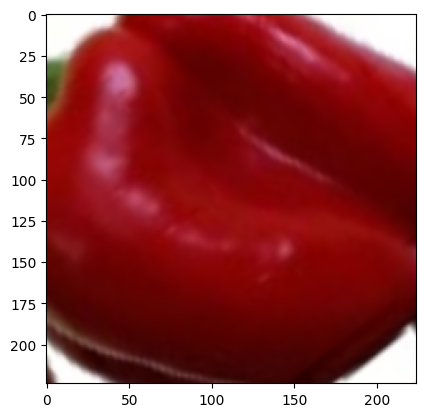

In [ ]:
# sample image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)
image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 46.8 ms, sys: 2.12 ms, total: 48.9 ms
Wall time: 57.1 ms
(32, 224, 224, 3)
(32, 131)


Peach Flat


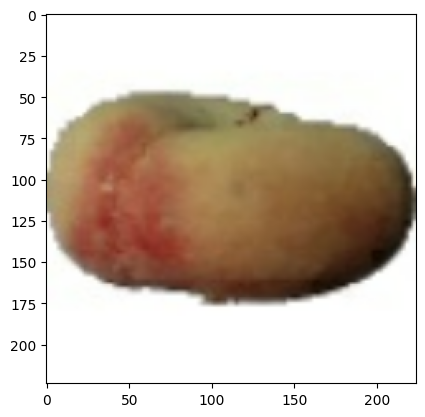

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(224 , 224 , 3))

In [ ]:
#ResNet50V2 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False #the final fully connected layers (top) of the ResNet50V2 model are excluded, making it suitable for feature extraction
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(131, activation='softmax') #has 131 units (neurons), softmax, which provides the probability distribution over the classes.
])

model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 131)               268419    
                                                                 
Total params: 23,833,219
Trainable params: 23,787,779
Non-trainable params: 45,440
_________________________________________________________________


In [ ]:
#compiling model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    #epsilon=1e-07: A small value added to the denominator for numerical stability. It prevents division by zero.
    loss = 'categorical_crossentropy',
    #Categorical cross-entropy measures the difference between the true class probabilities and the predicted class probabilities.
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=1,
    #callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
)

1194/1586 [=====================>........] - ETA: 2:14:11 - loss: 0.5692 - accuracy: 0.8416 - precision: 0.9193 - recall: 0.7955

In [ ]:
model.layers[0].trainable = False
#Setting a layer to be non-trainable means that the parameters of that layer will not be updated during the training process
# By freezing the weights of the pre-trained backbone we can leverage the knowledge it has learned from a large dataset

In [ ]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

tf.keras.callbacks.ModelCheckpoint: allows you to save the best model weights based on a certain metric (usually validation accuracy or loss) during the training process.

"best_weights.h5": This specifies the filename to save the best model weights. The .h5 indicates Hierarchical Data Format (HDF5) format, which is a common format for storing large numerical datasets.

verbose=1: This parameter controls the verbosity of the callback. Setting it to 1 means that a message will be printed to the console when the callback is triggered, indicating that the best weights have been saved.

EarlyStopping:
tf.keras.callbacks.EarlyStopping: This is another Keras callback that stops the training process early if a certain condition is met. It helps prevent overfitting by monitoring a specified metric (e.g., validation loss) and stopping training if the metric does not improve for a certain number of epochs.

patience=4: This parameter specifies the number of epochs with no improvement in the monitored metric before training is stopped. In this case, if the validation metric (e.g., validation loss) does not improve for four consecutive epochs, training will be halted.

In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=2,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
)